In [169]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [170]:
dataset = load_iris()
df = pd.DataFrame(dataset.data, columns = dataset.feature_names)
df['target'] = dataset.target
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [171]:
#Remover dados indesejados

df = df[['sepal length (cm)', 'sepal width (cm)','target']]
filtered_df = df[~(df.target == 1)]
filtered_df['target'] = filtered_df['target'].map({0:'setosa', 2:'virginica'})
filtered_df

<ipython-input-171-735d0d317603>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['target'] = filtered_df['target'].map({0:'setosa', 2:'virginica'})


,sepal length (cm),sepal width (cm),target
0,5.1,3.5,setosa
1,4.9,3.0,setosa
2,4.7,3.2,setosa
3,4.6,3.1,setosa
4,5.0,3.6,setosa
...,...,...,...
145,6.7,3.0,virginica
146,6.3,2.5,virginica
147,6.5,3.0,virginica
148,6.2,3.4,virginica


In [172]:
# Remover lixo ou informação mal formatada

filtered_df.columns = [c.replace(' ', '_') for c in filtered_df]
filtered_df.columns = [c.lstrip() for c in filtered_df]
filtered_df.columns = [c.rstrip() for c in filtered_df]
filtered_df

,sepal_length_(cm),sepal_width_(cm),target
0,5.1,3.5,setosa
1,4.9,3.0,setosa
2,4.7,3.2,setosa
3,4.6,3.1,setosa
4,5.0,3.6,setosa
...,...,...,...
145,6.7,3.0,virginica
146,6.3,2.5,virginica
147,6.5,3.0,virginica
148,6.2,3.4,virginica


In [408]:
class LinearClassifier:
    slope: float
    constant: float = 0
    class_label: str
    class_names: list = list()
    features: dict = dict()
    position: dict = dict()
    confusion_matrix: np.array

    def __init__(self, class_label, class_names, features):
        self.class_label = class_label
        self.class_names = class_names
        self.features['x'] = features[0]
        self.features['y'] = features[1]
    
    def get_confusion_matrix(self):
        return np.array(self.confusion_matrix)

    def initial_guess(self, df: pd.DataFrame):
        self.define_relative_position(df)

        # Achar os pontos máximo e mínimo do primeiro rótulo
        partial_df = df[df[self.class_label] == self.class_names[0]]    
        x_max_c1, y_max_c1, x_min_c1, y_min_c1 = self.find_extreme_points(partial_df)

        # Achar os pontos máximo e mínimo do segundo rótulo
        partial_df = df[df[self.class_label] == self.class_names[1]]
        x_max_c2, y_max_c2, x_min_c2, y_min_c2 = self.find_extreme_points(partial_df)

        mid_point_max = [(x_max_c1 + x_max_c2)/2,(y_max_c1 + y_max_c2)/2]
        mid_point_min = [(x_min_c1 + x_min_c2)/2,(y_min_c1 + y_min_c2)/2]

        self.slope = (mid_point_max[1] - mid_point_min[1])/(mid_point_max[0] - mid_point_min[1])
      
    def find_curve(self, df: pd.DataFrame, max_iterations: int = 20, sufficient_accuracy: float = 0.95):
        self.initial_guess(df)
        signal = 1
        acc = 0
        gain = 0.5

        while acc < sufficient_accuracy and max_iterations > 0:
            self.classify_samples(df)
            cm = self.get_confusion_matrix()            
            fp = cm[1][0]
            fn = cm[0][1]

            # constante muito alta ou muito baixa em relação aos positivos
            if fn > fp:
                if self.position['Above'] == self.class_names[0]:
                    signal = -1
                if self.position['Below'] == self.class_names[0]:
                    signal = 1
            # constante muito alta ou muito baixa em relação aos negativos
            if fp > fn:
                if self.position['Above'] == self.class_names[1]:
                    signal = -1
                if self.position['Below'] == self.class_names[1]:
                    signal = 1
        
            acc = self.get_accuracy()
            error = 1 - acc
            self.constant += error*signal*gain
            
            max_iterations -= 1

    def define_relative_position(self, df: pd.DataFrame):
        feature_values = df[df[self.class_label] == self.class_names[0]]
        feature_values = feature_values[self.features['y']]
        mean_ft1 = feature_values.mean()
        
        feature_values = df[df[self.class_label] == self.class_names[1]]
        feature_values = feature_values[self.features['y']]
        mean_ft2 = feature_values.mean()

        if mean_ft1 > mean_ft2:
            self.position['Above'] = self.class_names[0]
            self.position['Below'] = self.class_names[1]
            return
        
        self.position['Above'] = self.class_names[1]
        self.position['Below'] = self.class_names[0]

    def find_extreme_points(self, df):
        x_max = df[self.features['x']].max()
        x_min = df[self.features['x']].min()

        y_values = df[df[self.features['x']] == x_max]
        y_max = y_values[self.features['y']].max()
        
        y_values = df[df[self.features['x']] == x_min]
        y_min = y_values[self.features['y']].min()

        return x_max, y_max, x_min, y_min

    def classify_samples(self, df: pd.DataFrame):
        self.confusion_matrix = np.zeros((2,2))
        
        for index in df.index:
            example = df.loc[index]
            classification = ""

            x = example[self.features['x']]
            y = example[self.features['y']]
            true_class = example[self.class_label]

            if self.slope*x + self.constant > y:
                classification = self.position['Below']
            else:
                classification = self.position['Above']
            
            self.classify_inference(classification, true_class, self.class_names)

    def get_accuracy(self):
        return (self.confusion_matrix[0][0]+self.confusion_matrix[1][1])/(self.confusion_matrix[0][0]+self.confusion_matrix[0][1]+self.confusion_matrix[1][0]+self.confusion_matrix[1][1])

    def classify_inference(self, classification, true_class, class_names):
        if classification == true_class and classification == class_names[0]:
            self.confusion_matrix[0][0] += 1
            return
        if classification == true_class and classification == class_names[1]:
            self.confusion_matrix[1][1] += 1
            return
        if classification != true_class and classification == class_names[0]:
            self.confusion_matrix[1][0] += 1
            return
        if classification != true_class and classification == class_names[1]:
            self.confusion_matrix[0][1] += 1
            return

    def split_dataset(self, dataset, proportion):
        train_data, test_data, _, _ = train_test_split(dataset,dataset,test_size=proportion,random_state=None)
        return train_data, test_data
          

In [409]:
class_labels = filtered_df['target'].unique()
lc = LinearClassifier('target', class_labels, filtered_df.drop('target',axis='columns').columns)
train_data, test_data = lc.split_dataset(filtered_df,0.3)

lc.find_curve(train_data, max_iterations=14, sufficient_accuracy=0.99)
lc.classify_samples(test_data)
print("Accuracy:", lc.get_accuracy())

Accuracy: 1.0


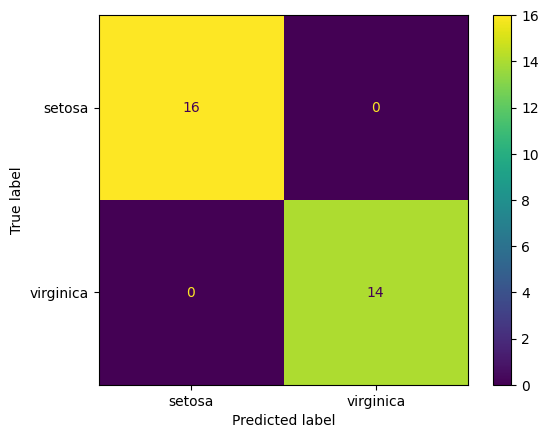

In [410]:
cm = lc.get_confusion_matrix()
cm = ConfusionMatrixDisplay(cm,display_labels=class_labels)

cm.plot()
plt.show()